# All Subtypes  @ scale 12
Lazy man result overview for anything

In [1]:
# Imports
import os
import glob
import time
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.sandbox.stats import multicomp as smi

In [2]:
%matplotlib inline

# Paths

In [3]:
# Variables
subtypes = 5
scale = 12
mtp = 'rmap_part'
name = 'site_279_sample'

# Fixed values
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
in_path = '/data1/subtypes/serial_preps/'
out_path = '/data1/subtypes/maps/{}/{}/'.format(mtp, name)
if not os.path.isdir(out_path):
    os.makedirs(out_path)
out_tmpl = os.path.join(out_path, 'sc{}_net_'.format(scale) + '_sbt_{}.nii.gz')

netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))
corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(mtp, name, scale))

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [6]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

In [7]:
# Network name lookup table
sc7_names = [
             'Cerebellum',
             'Limbic',
             'Somatomotor',
             'Visual',
             'Default Mode',
             'Frontoparietal',
             'Ventral Attention'
            ]
sc12_names = [
              'Basal Ganglia',
              'Auditory',
              'Limbic',
              'Lateral Default Mode',
              'Visual',
              'Posterior medial Default Mode',
              'Somatomotor',
              'Anterior Default Mode',
              'Dorsal Attention',
              'Frontoparietal',
              'Ventral Attention',
              'Cerebellum'
              ]

# Define some functions and the niak colormap

In [11]:
# Define the allrounder function
def get_data(scale, maptype, name, subtypes):
    # Get the paths
    netstack_path = os.path.join(in_path, 'netstack_dmn_{}_{}_scale_{:03d}.npy'.format(maptype, name, scale))
    netraw_path = os.path.join(in_path, 'netstack_raw_{}_{}_scale_{:03d}.npy'.format(maptype, name, scale))
    corrmat_path = os.path.join(in_path, 'correlation_matrix_{}_{}_scale_{:03d}.npy'.format(maptype, name, scale))
    # Get the files
    netstack = np.load(netstack_path)
    corr_mat = np.load(corrmat_path)
    
    # Make the subtypes
    subtypes = 5
    scale = netstack.shape[0]
    n_sub = netstack.shape[2]
    n_vox = netstack.shape[1]

    link_store = np.zeros((n_sub-1,4,scale))
    part_store = np.zeros((scale, n_sub))
    sbt_store = np.zeros((scale, subtypes, n_vox))
    weight_store = np.zeros((scale, subtypes, n_sub))
    
    # Iterate through the networks
    for net_id in range(scale):
        # Compute linkage with Ward's criterion
        link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
        link_store[..., net_id] = link_mat
        # Partition the linkage to get a given number of subtypes
        part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
        part_store[net_id, :] = part_sub

        sub_stack = np.zeros((n_vox, subtypes))
        for s_id in range(subtypes):
            sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
            sub_stack[:,s_id] = sbt
            sbt_store[net_id, s_id, :] = sbt

        # Init store - Compute the weights
        for s_id in range(subtypes):
            type_map = sub_stack[:, s_id]
            weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

    return (corr_mat, weight_store, sbt_store)

In [12]:
(corr_mat, weight_store, sbt_store) = get_data(scale, mtp, name, subtypes)

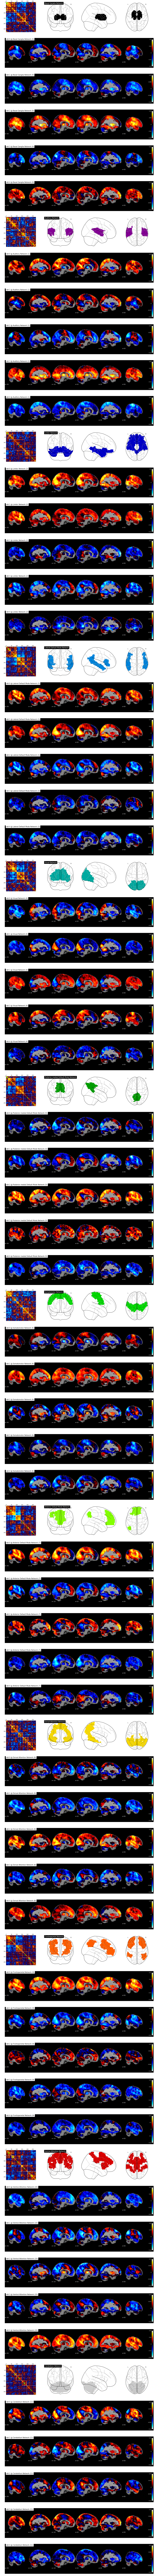

In [26]:
vr = 0.2

# Start the figure
n_figs = scale * subtypes + scale
fig = plt.figure(figsize=(25,6*n_figs))
gs = gridspec.GridSpec(n_figs, 4)

# Setup the text overlay
font = {'family': 'serif',
    'color':  'lime',
    'weight': 'heavy',
    'size': 18,
    }
txt_offset=8

counter = 0
# Iterate through the networks
for network in np.arange(scale):
    
    # Get the order of the network
    link_mat = scl.hierarchy.linkage(corr_mat[network, ...] , method='ward')
    ind = scl.hierarchy.dendrogram(link_mat, no_plot=True)['leaves']
    tmp = corr_mat[network, ...]
    show_mat = tmp[ind, :][:, ind]
    part_frame = np.zeros(show_mat.shape)
    part_test = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')[ind]
    text_loc = list()
    
    # Prepare the text overlay
    for sbt_id in np.arange(subtypes):
        # Get first and last element
        hits = np.where(part_test==sbt_id+1)[0]
        first = hits[0]
        last = hits[-1]
        text_loc.append((len(hits)/2 + first-txt_offset, len(hits)/2 + first+txt_offset))
        # Draw column
        part_frame[first:last, (first, last)] = 1
        # Draw rows
        part_frame[(first, last), first:last] = 1
    part_frame = np.ma.masked_where(part_frame == 0, part_frame)

    # Plot for the network
    ax1a = fig.add_subplot(gs[counter, 0])
    ax1a.matshow(show_mat, vmin=-vr, vmax=vr, cmap=bb.visu.hot_cold())
    ax1a.matshow(part_frame, cmap=plt.cm.Greys)
    for sbt_id in np.arange(subtypes):
        (x,y) = text_loc[sbt_id]
        ax1a.text(x,y,'{}'.format(sbt_id), fontdict=font)

    ax1b = fig.add_subplot(gs[counter, 1:])
    nlp.plot_glass_brain(nil.image.index_img(prior_img, network), cmap=plt.cm.spectral, 
                                 colorbar=False, vmin=1, vmax=scale,axes=ax1b,
                                title='{} Network'.format(sc12_names[network]))
    counter += 1
    # Go through the subtypes
    for sbt in np.arange(subtypes):
        
        ax2 = fig.add_subplot(gs[counter, :])
        # Show the subtype
        sbt_map = sbt_store[network, sbt,:]
        tmp = np.zeros_like(mask, dtype=np.float)
        tmp[mask] = sbt_map
        sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
        nlp.plot_stat_map(sbt_img, display_mode='x', threshold=0, 
                      cut_coords=[-50, -30, -10, 10, 30, 50], black_bg=True,axes=ax2,
                         title='sbt {} @ {} Network ({})'.format(sbt, sc12_names[network], network))
        counter += 1